In [1]:
import cv2
import time
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Use 'jpeg' instead of 'png' (~5 times faster)
def array_to_image(a, fmt='jpeg'):
    #Create binary stream object
    f = BytesIO()
    #Convert array to binary stream object
    PIL.Image.fromarray(a).save(f, fmt)
    return IPython.display.Image(data=f.getvalue())

In [3]:
# Adaptive Histogram Equalization
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# adapt_img = clahe.apply(img)

# Create an averaging filter by hand.
# kernel = np.ones((15,15),np.float32)/225
# Apply it.
# dst = cv2.filter2D(img, ddepth=cv2.CV_8U, kernel=kernel)

# Gaussian Blue Filter
# blur = cv2.GaussianBlur(img,(15,15),sigmaX=3)

In [4]:
# sobelx_kernel = np.array([
# [-1, 0, 1],
# [-2, 0, 2],
# [-1, 0, 1],
# ])

# # Apply mask to image. Output image can contain negative values,
# # so make the depth of the output image CV_32F (ie., floating).
# sobelx = cv2.filter2D(img, ddepth=cv2.CV_32F, kernel=sobelx_kernel)

# # Scale (for display purposes only).
# # Min value is set to alpha, max value to beta.
# result_display = cv2.normalize(
# src = sobelx, dst = None, alpha = 0, beta = 1,
# norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)


# Instead of creating the kernel and doing filter2D, just do this.
# sobelx = cv2.Sobel(img, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)

In [5]:
def getUserTemplate(img):

    # Select ROI
    try:
        r = cv2.selectROI("ROI Template Selection", img)
        # All these waitkeys are a hack to get the OpenCV window to close
        x, y, w, h = r
        # Crop image
        imCrop = img[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
        original_with_ROI=cv2.rectangle(img=img, pt1=(x, y), pt2=(x + w, y + h), color=(0, 0, 255), thickness=2)
    finally:
        cv2.destroyAllWindows()
        return original_with_ROI, imCrop, w, h





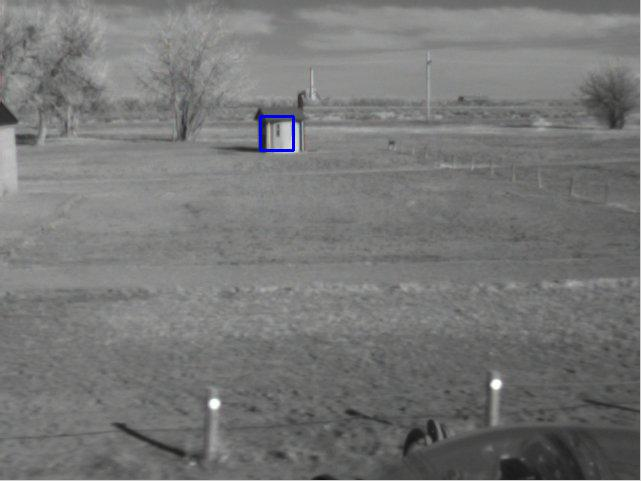

In [6]:
# Blue color in BGR 
color = (255, 0, 0) 

# Line thickness of 2 px 
thickness = 2

video_name = "building.avi"
video_output_name = video_name[0:video_name.find(".")]+"_output"+".avi"
cam = cv2.VideoCapture(video_name)

fps = 30
frames = 0
total_frames = int(cam.get(cv2.CAP_PROP_FRAME_COUNT))

d1 = IPython.display.display("", display_id=1)
# d2 = IPython.display.display("", display_id=2)
d3 = IPython.display.display("", display_id=3)
s = f""""""

d3.update( IPython.display.HTML(s) )
# Create output movie file.
fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')
videoWriter = cv2.VideoWriter(apiPreference=cv2.CAP_FFMPEG, filename=video_output_name, fourcc=fourcc, fps=30,
                              frameSize=(int(cam.get(3)), int(cam.get(4))))

In [7]:
template_scores_by_frame = []
try:
    got_image, img = cam.read()
    template_img, template, template_width, template_height = getUserTemplate(img)
    cv2.imshow("1st frame with ROI", template_img)
    cv2.waitKey(0)
    cv2.destroyWindow("1st frame with ROI")
    height, width, channels = img.shape
    # find template scores for img
    template_offset_x, template_offset_y, template_channels = template.shape
    print(template.shape)
    while True:
        try:
            t1 = time.time()
            got_image, img = cam.read()
            if not got_image:
                break
            
            
            

            scores = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(scores)
            template_scores_by_frame.append(max_val)
            xCenter, yCenter = max_loc
            x1 = int(xCenter - ((template_width-1)/2))
            x2 = int(xCenter + template_width)
            y1 = int(yCenter - ((template_height-1)/2))
            y2 = int(yCenter + template_height)
            

            template_frame = cv2.rectangle(img=img, pt1=(xCenter, yCenter), pt2=(x2, y2), color=(0, 0, 255), thickness=2)


            videoWriter.write(template_frame)
            
            # Jupyter Video output display
            template_img = cv2.cvtColor(template_frame, cv2.COLOR_BGR2RGB)
            cv2.imshow("Template Tracking", template_frame)
            
            cv2.waitKey(0)
            cv2.cvtColor(template_frame, cv2.COLOR_BGR2RGB)
            d1.update(array_to_image(template_frame))
            while time.time() < t1 + (1/(fps+ 1)):
                continue
            t2 = time.time()
            s = f"""<h1>{int(1/(t2-t1))} FPS</h1>"""
            d3.update( IPython.display.HTML(s) )
        except KeyboardInterrupt:
            cam.release()
            videoWriter.release()
            print ("Stream stopped by Keyboard")
            break

finally:
    cam.release()
    videoWriter.release()
    cv2.destroyAllWindows()
    IPython.display.clear_output()
    print("Average Max Correlation:\t", np.average(np.array(template_scores_by_frame)))
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(np.array(template_scores_by_frame))
    print("Max:\t",max_val, "\tMin:\t",min_val)
    print("Output Video Saved")
    print("End of Video")
    
    

Average Max Correlation:	 0.5738851979597291
Max:	 0.618484377861023 	Min:	 0.5001864433288574
Output Video Saved
End of Video


2. Experiment with the choice of template that you extract from the first image. Try the corner of the window (point 1), the edge of the roof (point 2), the middle of the wall (point 3), and the sign next to the door (point 4). Which point seems to allow the best tracking, and why? (Note - the match may not be correct in every single image, no matter which point you pick.)
<img src="https://elearning.mines.edu/courses/25410/files/1886668/download?wrap=1">

Max Correlation per Template
* 1: 0.6116206049919128; Poor tracking due to there being 4 similar windows. It had a hard time choosing between them.
* 2: 0.663144052028656; Poor tracking due to the whole roof line looking the same. couldn't decern which part.
* 3: 0.4707816541194916; Poor tracking due to the wall of the building looking the same.
* 4: 0.6684865951538086; Good tracking. The door frame, sign combo makes a distinct template that is able to track the unique area better.

3. When the template is matched correctly, approximately what correlation scores do you see?
* With the template that tracked the best (4). The correlations scores were:

Average Max Correlation:	 0.6083123586071071

Max:	 0.649455189704895 	

Min:	 0.5225228071212769

In [8]:
# # The scores image is smaller than the input image by half the
# # template size, along each side and top and bottom
# # • You should add half the template size to the detected (x,y)
# # coordinates from the scores image
# # • Namely, if the template size is (2*M+1)x(2*M+1), add M to
# # the detected (x,y) coordinates
# scores = cv2.matchTemplate(img, template, method=cv2.CV_TM_CCOEFF_NORMED)

# # To find the (single) highest and lowest value:
# min_val, max_val, min_loc,
# max_loc = cv2.minMaxLoc(scores)

# threshold = 0.8
# # To find all matches greater than a threshold:
# np.where(threshold >= maxVal)
